In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import seaborn as sns
import xarray as xr
from sklearn.preprocessing import RobustScaler
from torch import optim

from model.neural_network import NN_wrapper
from pipeline.backtest import cross_validation, evaluation_for_submission
from matplotlib import pyplot as plt

from visualization.metric import plot_performance
from pandas import DataFrame
sns.set_theme(style="whitegrid")


In [3]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')


In [4]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc/fundamental_v0.nc')
ds = base_ds.merge(market_brief_ds).merge(fundamental_v0_ds)


In [5]:
ds_extend = ds.copy()


In [6]:
ds_extend


<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/29)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    earnings           (day, asset) float64 ...
    book               (day, asset) float64 ...
    sales              (day, asset) float64 ...
    cashflow           (day, asset) float64 ...
    market_cap         (asset, day) float64 ...
    market_share       (asset) float64 ...

## Check CUDA

In [7]:
import torch

IS_CUDA = torch.cuda.is_available()
IS_CUDA


True

## CV and Eval

In [22]:
def winsorize(X, q=0.1):
    lower = X.quantile(q)
    upper = X.quantile(1-q)
    return X.clip(lower, upper, axis=1)

class CombinedScaler:
    def __init__(self):
        self.scaler = RobustScaler()

    def fit_transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.fit_transform(X)

    def transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.transform(X)

feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
train_lookback = 16
eval_lookback = 16
preprocess = CombinedScaler()
lr = 1e-3
n_epoch = 20
constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
                                                    cycle_momentum=False)

### CV

In [23]:
model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=64, n_asset=54,
                   network='CONV', feature_name=feature, load_model_path=None,
                   embed_asset=False, embed_offset=False,
                   is_cuda=IS_CUDA)
ds_cv = ds_extend.sel(day=slice(200, ds.dims['day'] - 2))[feature + ['return']]
performance_cv, cum_y_df = cross_validation(model, feature, ds=ds_cv, train_lookback=train_lookback,
                                            per_eval_lookback=eval_lookback)


  0%|          | 0/767 [00:00<?, ?it/s]

Final learning rate: 0.0001
Final learning rate: 0.0001


### Eval

In [28]:
load_model_path = '../../model/dump/2023-02-28/2023-02-28_CONV1'

model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=128, n_asset=54,
                   network='CONV', feature_name=feature, load_model_path=load_model_path,
                   embed_asset=False, embed_offset=False,
                   is_eval=True,
                   is_cuda=IS_CUDA)
performance_eval = evaluation_for_submission(model, given_ds=ds, lookback_window=train_lookback,
                                             per_eval_lookback=eval_lookback, qids=qids)


  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


## Results


### Transformer 1


In [28]:
# def winsorize(X, q=0.1):
#     lower = X.quantile(q)
#     upper = X.quantile(1-q)
#     return X.clip(lower, upper, axis=1)
#
# class CombinedScaler:
#     def __init__(self):
#         self.scaler = RobustScaler()
#
#     def fit_transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.fit_transform(X)
#
#     def transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.transform(X)
#
# feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
# train_lookback = 16
# eval_lookback = 16
# preprocess = CombinedScaler()
# lr = 1e-4
# n_epoch = 20
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
# load_model_path = '../../model/dump/2023-02-28/2023-02-28_Transformer1'


The ending score for metric train_r2 is: 1.9739e-01
The ending score for metric val_cum_r2 is: -1.1976e-01
The ending score for metric val_cum_pearson is: 6.9778e-03


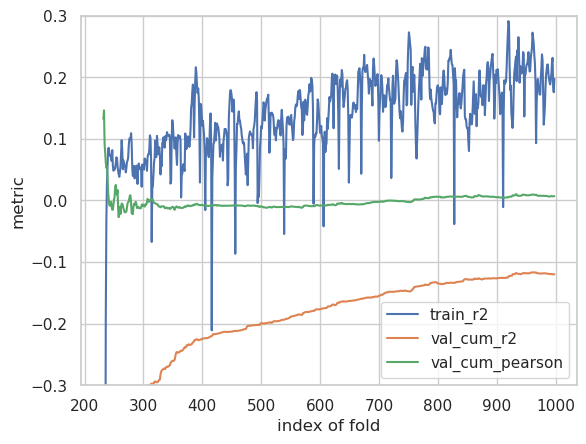

In [24]:
plt.figure()
plot_performance(performance_cv, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.3, 0.3])
plt.show()


The ending score for metric train_r2 is: 2.4580e-01
The ending score for metric test_cum_r2 is: -1.5440e-01
The ending score for metric test_cum_pearson is: 1.5392e-02


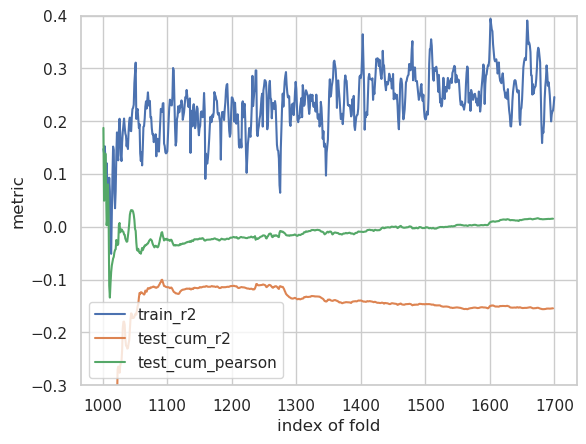

In [26]:
plt.figure()
plot_performance(performance_eval, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.ylim([-0.3, 0.4])
plt.show()


### LSTM 1

In [ ]:
# def winsorize(X, q=0.1):
#     lower = X.quantile(q)
#     upper = X.quantile(1-q)
#     return X.clip(lower, upper, axis=1)
#
# class CombinedScaler:
#     def __init__(self):
#         self.scaler = RobustScaler()
#
#     def fit_transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.fit_transform(X)
#
#     def transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.transform(X)
#
# feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
# train_lookback = 16
# eval_lookback = 16
# preprocess = CombinedScaler()
# lr = 1e-4
# n_epoch = 40
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
# hidden_state = 128

The ending score for metric train_r2 is: 1.7963e-01
The ending score for metric val_cum_r2 is: -1.0432e-01
The ending score for metric val_cum_pearson is: -2.7049e-03


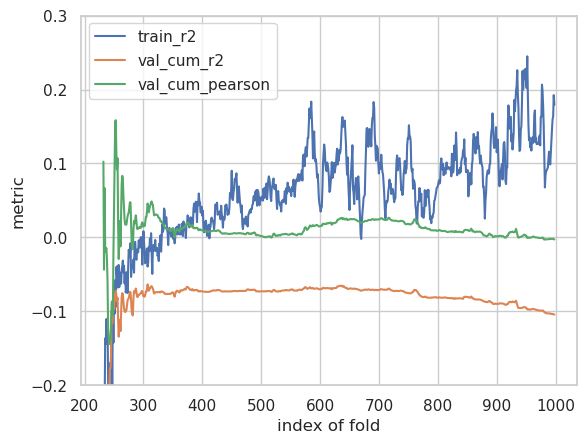

In [33]:
plt.figure()
plot_performance(performance_cv, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.2, 0.3])
plt.show()


The ending score for metric train_r2 is: 2.9296e-01
The ending score for metric test_cum_r2 is: -3.0146e-01
The ending score for metric test_cum_pearson is: -7.3496e-03


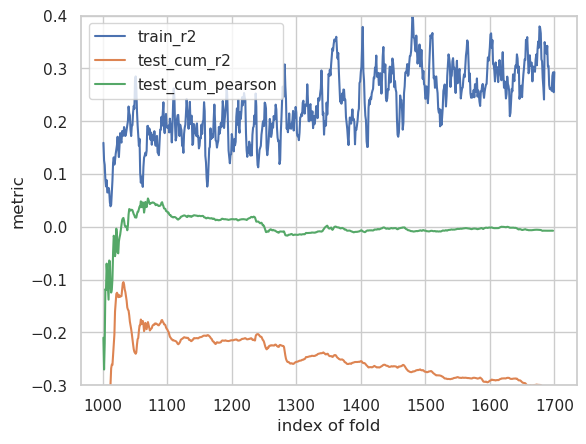

In [34]:
plt.figure()
plot_performance(performance_eval, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.ylim([-0.3, 0.4])
plt.show()


### MLP


In [ ]:
# def winsorize(X, q=0.1):
#     lower = X.quantile(q)
#     upper = X.quantile(1-q)
#     return X.clip(lower, upper, axis=1)
#
# class CombinedScaler:
#     def __init__(self):
#         self.scaler = RobustScaler()
#
#     def fit_transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.fit_transform(X)
#
#     def transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.transform(X)
#
# feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
# train_lookback = 32
# eval_lookback = 32
# preprocess = CombinedScaler()
# lr = 1e-3
# n_epoch = 40
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
#
# model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
#                    train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=256, n_asset=54,
#                    network='MLP', feature_name=feature, load_model_path=None,
#                    embed_asset=False, embed_offset=False,
#                    is_cuda=IS_CUDA)

The ending score for metric train_r2 is: 5.2761e-01
The ending score for metric val_cum_r2 is: -3.9828e-01
The ending score for metric val_cum_pearson is: -1.0940e-02


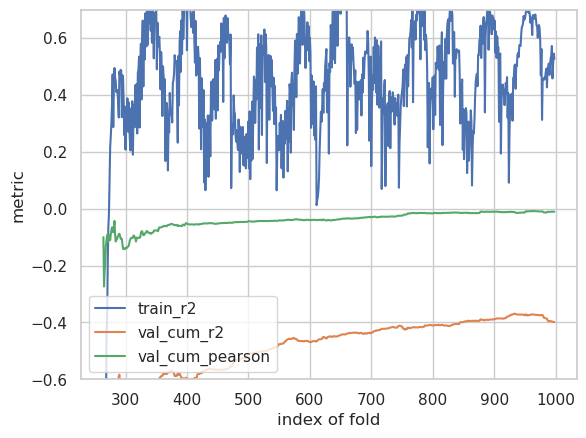

In [12]:
plt.figure()
plot_performance(performance_cv, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.6, 0.7])
plt.show()


The ending score for metric train_r2 is: 5.8816e-01
The ending score for metric test_cum_r2 is: -3.9388e-01
The ending score for metric test_cum_pearson is: -1.7076e-02


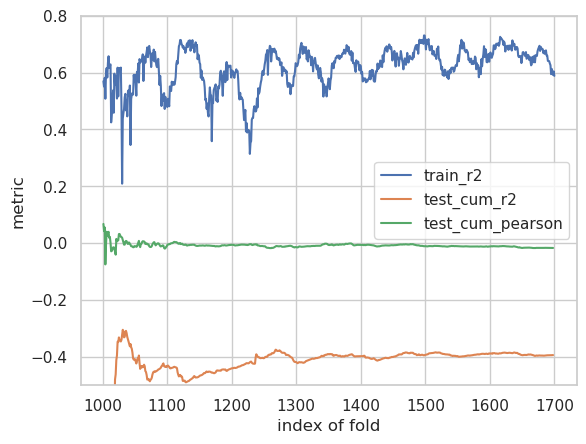

In [16]:
plt.figure()
plot_performance(performance_eval, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.ylim([-0.5, 0.8])
plt.show()


### CONV


In [ ]:
# def winsorize(X, q=0.1):
#     lower = X.quantile(q)
#     upper = X.quantile(1-q)
#     return X.clip(lower, upper, axis=1)
#
# class CombinedScaler:
#     def __init__(self):
#         self.scaler = RobustScaler()
#
#     def fit_transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.fit_transform(X)
#
#     def transform(self, X):
#         X = winsorize(DataFrame(X))
#         return self.scaler.transform(X)
#
# feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
# train_lookback = 16
# eval_lookback = 16
# preprocess = CombinedScaler()
# lr = 1e-3
# n_epoch = 20
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
#
# model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
#                    train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=64, n_asset=54,
#                    network='CONV', feature_name=feature, load_model_path=None,
#                    embed_asset=False, embed_offset=False,
#                    is_cuda=IS_CUDA)


The ending score for metric train_r2 is: 8.9227e-01
The ending score for metric val_cum_r2 is: -2.0766e+00
The ending score for metric val_cum_pearson is: 3.6259e-02


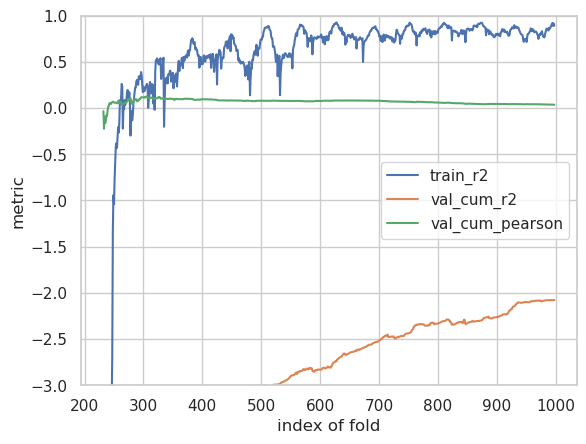

In [27]:
plt.figure()
plot_performance(performance_cv, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-3, 1])
plt.show()


The ending score for metric train_r2 is: 8.1609e-01
The ending score for metric test_cum_r2 is: -1.0501e+00
The ending score for metric test_cum_pearson is: -2.3104e-02


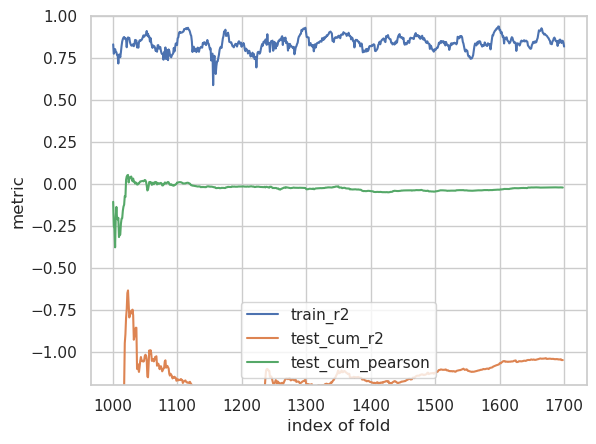

In [30]:
plt.figure()
plot_performance(performance_eval, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.ylim([-1.2, 1])
plt.show()
